In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import timm
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

C:\Users\atom\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
path = 'train_audio'
bs = 64

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((200, 800)),
    transforms.Normalize(mean=0.5, std=0.25)
])

In [5]:
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    augmented_data = np.clip(augmented_data, -1, 1)
    return augmented_data

In [6]:
class CustomDataset(Dataset):
    def __init__(self, audio, labels, transform=None, spectrogram_type='mel', augment_audio=False):
        self.audios_path = audio
        self.labels = labels
        self.transform = transform
        self.spectrogram_type = spectrogram_type
        self.augment_audio=augment_audio

    def __len__(self):
        return len(self.audios_path)

    def __getitem__(self, index):
        y, sr = librosa.load(self.audios_path[index])

        if self.augment_audio:
            y = add_noise(y)
        
        if self.spectrogram_type == 'mel': # mel spectrogram
            spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        elif self.spectrogram_type == 'stft': # Short-Time Fourier Transform  spectrogram
            D = librosa.stft(y)
            spectrogram = np.abs(D)
        elif self.spectrogram_type == 'cqt': # constant-Q Transform spectrogram
            C = librosa.cqt(y, sr=sr)
            spectrogram = np.abs(C)
        elif self.spectrogram_type == 'chroma': # chroma spectrogram 
            spectrogram = librosa.feature.chroma_stft(y=y, sr=sr)
        elif self.spectrogram_type == 'sc': # spectral contrast spectrogram
            spectrogram = librosa.feature.spectral_contrast(y=y, sr=sr)
        else:
            raise ValueError(f"Unsupported spectrogram type: {self.spectrogram_type}")
        
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        spectrogram_img = PIL.Image.fromarray(spectrogram_db)
        
        if self.transform:
            image = self.transform(spectrogram_img)
        else:
            image = spectrogram_img
        
        return image, self.labels[index]

In [7]:
def load_data_paths(root_dir):
    audio_files = [f for f in os.listdir(root_dir) if f.endswith('.ogg')]
    paths = [os.path.join(root_dir, f) for f in audio_files]
    return paths

In [8]:
x_train, x_val = [], []
y_train, y_val = [], []

In [9]:
for folder in os.listdir(path):
    root = os.path.join(path, folder)
    files = [os.path.join(root, f) for f in os.listdir(root)]
    labels = [folder] * len(files)
    
    x_train_folder, x_val_folder, y_train_folder, y_val_folder = train_test_split(files, labels, test_size=0.2, random_state=42)
    
    x_train.extend(x_train_folder)
    x_val.extend(x_val_folder)
    y_train.extend(y_train_folder)
    y_val.extend(y_val_folder)

In [10]:
labels = os.listdir(path)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print(encoded_labels)
print(labels)

y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181]
['asbfly', 'ashdro1', 'ashpri1', 'ashwoo2', 'asikoe2', 'asiope1', 'aspfly1', 'aspswi1', 'barfly1', 'barswa', 'bcnher', 'bkcbul1', 'bkrfla1', 'bkskit1', 'bkwsti', 'bladro1', 'blaeag1', 'blakit1', 'blhori1', 'blnmon1', 'blrwar1', 'bncwoo3', 'brakit1', 'brasta1',

In [11]:
dataset_train_mel = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='mel')
dataset_val_mel = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='mel')

dataset_train_constantQ = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='cqt')
dataset_val_constantQ = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='cqt')

dataset_train_contrast = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='sc')
dataset_val_contrast = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='sc')

dataset_train_chroma = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='chroma')
dataset_val_chroma = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='chroma')

dataset_train_stft = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='stft')
dataset_val_stft = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='stft')

dataset_train_mel_aug = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='mel', augment_audio=True)
dataset_val_mel_aug = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='mel', augment_audio=True)

In [12]:
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=9):
    loss_list = []
    loss_list_val = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    loss_total = []
    loss_total_val = []
    accuracy_total = []
    precision_total = []
    recall_total = []
    f1_total = []
    
    len_loader = len(train_loader)
    model.train()
    for epoch in range(num_epochs):
        i = 1
        loss_list = []
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        for inputs, labels in train_loader:
            # if i == 10: break
            print(f'\rIteration: {i} / {len_loader}', end='', flush=True)
            i += 1
            inputs = inputs.to(device)
            labels = labels.long().to(device)
            # print(inputs.device.type == 'cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())

            # if i == 5: break
            
        print('\nValidating...')
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.long().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
                predictions = torch.argmax(outputs, dim=1)
                accuracy = accuracy_score(labels.cpu(), predictions.detach().cpu())
                precision = precision_score(labels.cpu(), predictions.detach().cpu(), average='macro')
                recall = recall_score(labels.cpu(), predictions.detach().cpu(), average='macro')
                f1 = f1_score(labels.cpu(), predictions.detach().cpu(), average='macro')

                loss_list_val.append(loss.item())
                accuracy_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)
                f1_list.append(f1)
        
                # print(f'Loss: {loss.item()}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}')
                # if i == 5: break
       

        loss = sum(loss_list) / len(loss_list)
        loss_val = sum(loss_list_val) / len(loss_list_val)
        accuracy = sum(accuracy_list) / len(accuracy_list)
        precision = sum(precision_list) / len(precision_list)
        recall = sum(recall_list) / len(recall_list)
        f1 = sum(f1_list) / len(f1_list)

        loss_total.append(loss)
        loss_total_val.append(loss_val)
        accuracy_total.append(accuracy)
        precision_total.append(precision)
        recall_total.append(recall)
        f1_total.append(f1)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}, Train loss: {loss:.3f}, Validation loss: {loss_val:.3f}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}')

    plt.plot(loss_total)
    plt.title('Train loss')
    plt.show()
    plt.plot(loss_total_val)
    plt.title('Validation loss')
    plt.show()
    plt.plot(accuracy_total, label='Accuracy')
    plt.plot(precision_total, label='Precision')
    plt.plot(recall_total, label='Recall')
    plt.plot(f1_total, label='F1-score')
    plt.legend()
    plt.show()

In [13]:
class ResNetGray182(nn.Module):
    def __init__(self, num_classes=182):
        super(ResNetGray182, self).__init__()
        resnet = models.resnet18(pretrained=False)
        # Изменяем первый слой, чтобы он принимал одноканальные изображения
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Копируем веса из оригинальной модели ResNet
        self.conv1.weight.data = resnet.conv1.weight.data.sum(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        # Изменяем последний полносвязный слой для 182 классов
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [14]:
train_loader_mel = DataLoader(dataset_train_mel, batch_size=bs, shuffle=True)
train_loader_contrast = DataLoader(dataset_train_contrast, batch_size=bs, shuffle=True)
train_loader_constantQ = DataLoader(dataset_train_constantQ, batch_size=bs, shuffle=True)
train_loader_stft = DataLoader(dataset_train_stft, batch_size=bs, shuffle=True)
train_loader_chroma = DataLoader(dataset_train_chroma, batch_size=bs, shuffle=True)
train_loader_mel_aug = DataLoader(dataset_train_mel_aug, batch_size=bs, shuffle=True)

val_loader_mel = DataLoader(dataset_val_mel, batch_size=bs, shuffle=True)
val_loader_contrast = DataLoader(dataset_val_contrast, batch_size=bs, shuffle=True)
val_loader_constantQ = DataLoader(dataset_val_constantQ, batch_size=bs, shuffle=True)
val_loader_stft = DataLoader(dataset_val_stft, batch_size=bs, shuffle=True)
val_loader_chroma = DataLoader(dataset_val_chroma, batch_size=bs, shuffle=True)

In [15]:
def launch(train_loader, val_loader, num_epochs=9, spectrogram_type='mel'):    
    model = ResNetGray182(num_classes=182).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    
    torch.save(model.state_dict(), f'ResNet_weights{num_epochs}_{spectrogram_type}.pth')

# Model training on the mel spectogram

Iteration: 305 / 305
Validating...
Epoch 1/9, Train loss: 3.773, Validation loss: 2.951, Accuracy: 0.315, Precision: 0.173, Recall: 0.222, F1-score: 0.178

Iteration: 305 / 305
Validating...
Epoch 2/9, Train loss: 2.995, Validation loss: 2.808, Accuracy: 0.378, Precision: 0.235, Recall: 0.268, F1-score: 0.234

Iteration: 305 / 305
Validating...
Epoch 3/9, Train loss: 2.390, Validation loss: 2.625, Accuracy: 0.461, Precision: 0.304, Recall: 0.336, F1-score: 0.303

Iteration: 305 / 305
Validating...
Epoch 4/9, Train loss: 2.055, Validation loss: 2.511, Accuracy: 0.489, Precision: 0.345, Recall: 0.362, F1-score: 0.337

Iteration: 305 / 305
Validating...
Epoch 5/9, Train loss: 1.810, Validation loss: 2.406, Accuracy: 0.520, Precision: 0.373, Recall: 0.388, F1-score: 0.363

Iteration: 305 / 305
Validating...
Epoch 6/9, Train loss: 1.572, Validation loss: 2.316, Accuracy: 0.546, Precision: 0.390, Recall: 0.405, F1-score: 0.383

Iteration: 305 / 305
Validating...
Epoch 7/9, Train loss: 1.351,

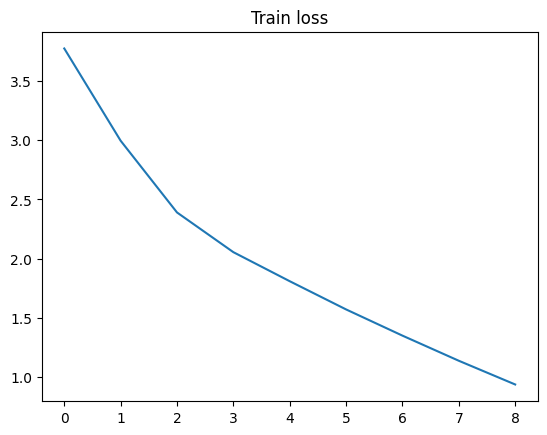

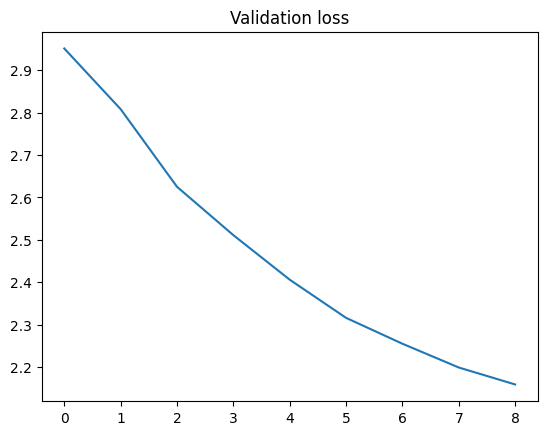

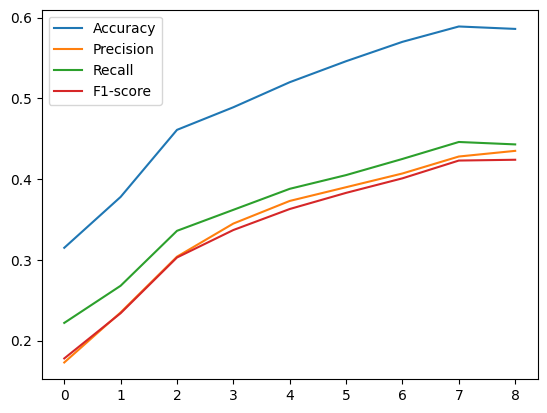

In [15]:
launch(train_loader=train_loader_mel, val_loader=val_loader_mel, num_epochs=9, spectrogram_type='mel')

In [18]:
loss_list = []
loss_list_val = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

loss_total = []
loss_total_val = []
accuracy_total = []
precision_total = []
recall_total = []
f1_total = []

# Model training on the spectral contrast

Iteration: 305 / 305
Validating...
Epoch 1/9, Train loss: 4.271, Validation loss: 4.930, Accuracy: 0.032, Precision: 0.008, Recall: 0.027, F1-score: 0.010

Iteration: 305 / 305
Validating...
Epoch 2/9, Train loss: 4.565, Validation loss: 4.558, Accuracy: 0.082, Precision: 0.027, Recall: 0.059, F1-score: 0.032

Iteration: 305 / 305
Validating...
Epoch 3/9, Train loss: 3.921, Validation loss: 4.299, Accuracy: 0.141, Precision: 0.067, Recall: 0.100, F1-score: 0.070

Iteration: 305 / 305
Validating...
Epoch 4/9, Train loss: 3.627, Validation loss: 4.146, Accuracy: 0.162, Precision: 0.087, Recall: 0.116, F1-score: 0.087

Iteration: 305 / 305
Validating...
Epoch 5/9, Train loss: 3.440, Validation loss: 4.010, Accuracy: 0.203, Precision: 0.121, Recall: 0.144, F1-score: 0.118

Iteration: 305 / 305
Validating...
Epoch 6/9, Train loss: 3.296, Validation loss: 3.908, Accuracy: 0.212, Precision: 0.118, Recall: 0.149, F1-score: 0.119

Iteration: 305 / 305
Validating...
Epoch 7/9, Train loss: 3.148,

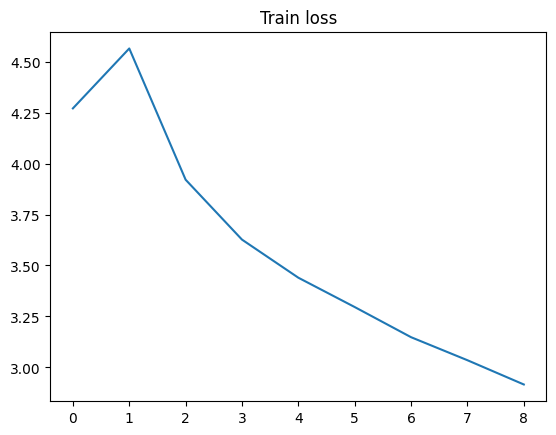

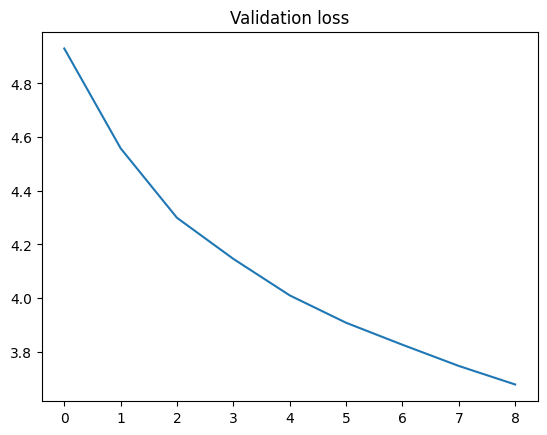

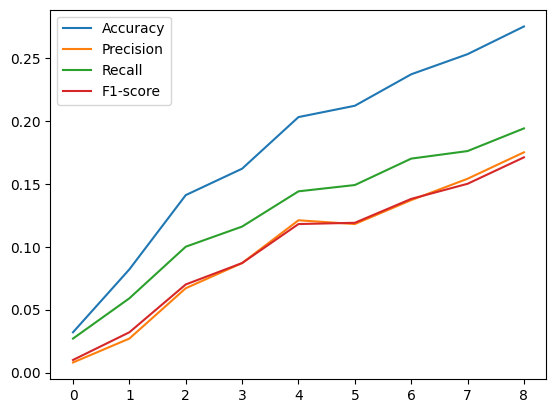

In [17]:
launch(train_loader=train_loader_contrast, val_loader=val_loader_contrast, num_epochs=9, spectrogram_type='sc')

# Model training on the constant-Q spectrogram

Iteration: 305 / 305
Validating...
Epoch 1/9, Train loss: 4.356, Validation loss: 3.956, Accuracy: 0.123, Precision: 0.062, Recall: 0.091, F1-score: 0.063

Iteration: 305 / 305
Validating...
Epoch 2/9, Train loss: 4.614, Validation loss: 4.213, Accuracy: 0.047, Precision: 0.015, Recall: 0.037, F1-score: 0.016

Iteration: 305 / 305
Validating...
Epoch 3/9, Train loss: 3.893, Validation loss: 4.013, Accuracy: 0.190, Precision: 0.103, Recall: 0.133, F1-score: 0.106

Iteration: 305 / 305
Validating...
Epoch 4/9, Train loss: 3.356, Validation loss: 3.829, Accuracy: 0.258, Precision: 0.153, Recall: 0.186, F1-score: 0.154

Iteration: 305 / 305
Validating...
Epoch 5/9, Train loss: 3.048, Validation loss: 3.672, Accuracy: 0.294, Precision: 0.181, Recall: 0.216, F1-score: 0.182

Iteration: 305 / 305
Validating...
Epoch 6/9, Train loss: 2.811, Validation loss: 3.548, Accuracy: 0.317, Precision: 0.199, Recall: 0.230, F1-score: 0.198

Iteration: 305 / 305
Validating...
Epoch 7/9, Train loss: 2.631,

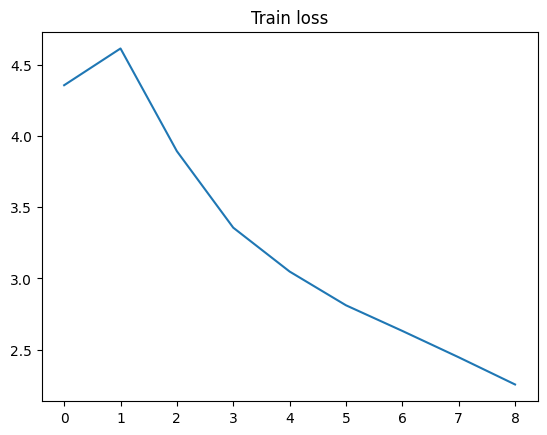

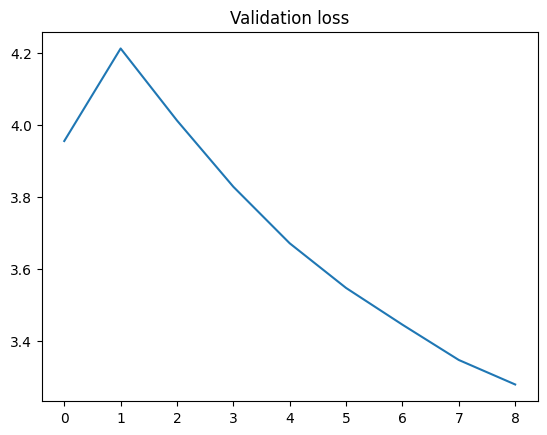

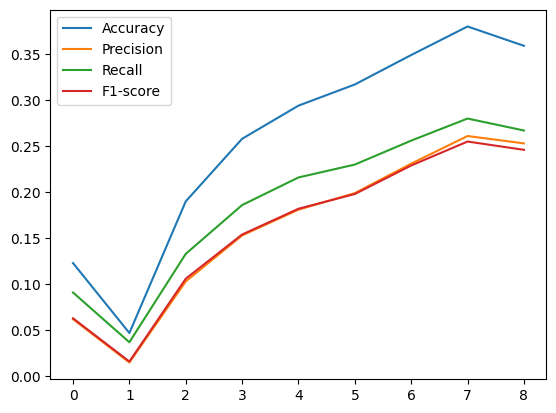

In [13]:
launch(train_loader=train_loader_constantQ, val_loader=val_loader_constantQ, num_epochs=9, spectrogram_type='cqt')

# Model training on the short-time fourier transform spectrogram

Iteration: 305 / 305
Validating...
Epoch 1/9, Train loss: 3.785, Validation loss: 3.151, Accuracy: 0.266, Precision: 0.159, Recall: 0.187, F1-score: 0.156

Iteration: 305 / 305
Validating...
Epoch 2/9, Train loss: 4.677, Validation loss: 3.741, Accuracy: 0.074, Precision: 0.027, Recall: 0.055, F1-score: 0.030

Iteration: 305 / 305
Validating...
Epoch 3/9, Train loss: 3.232, Validation loss: 3.424, Accuracy: 0.340, Precision: 0.215, Recall: 0.246, F1-score: 0.213

Iteration: 305 / 305
Validating...
Epoch 4/9, Train loss: 2.546, Validation loss: 3.182, Accuracy: 0.425, Precision: 0.268, Recall: 0.301, F1-score: 0.267

Iteration: 305 / 305
Validating...
Epoch 5/9, Train loss: 2.186, Validation loss: 2.995, Accuracy: 0.461, Precision: 0.315, Recall: 0.330, F1-score: 0.307

Iteration: 305 / 305
Validating...
Epoch 6/9, Train loss: 1.924, Validation loss: 2.844, Accuracy: 0.495, Precision: 0.328, Recall: 0.355, F1-score: 0.326

Iteration: 305 / 305
Validating...
Epoch 7/9, Train loss: 1.680,

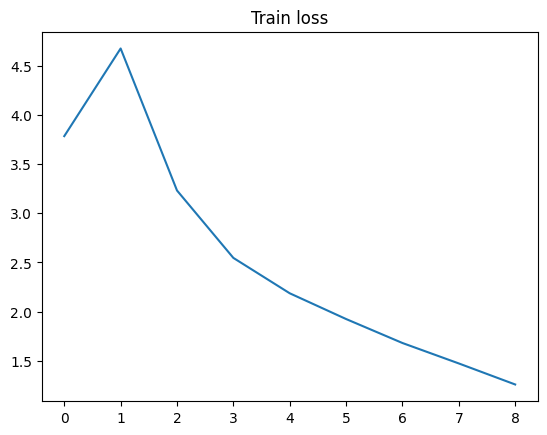

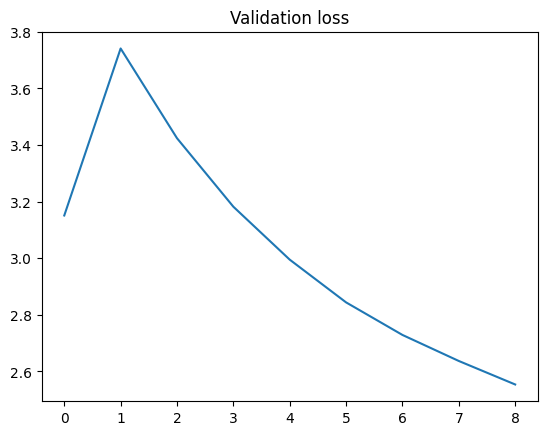

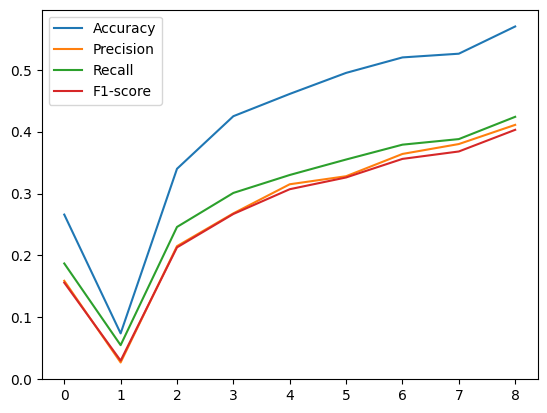

In [19]:
launch(train_loader=train_loader_stft, val_loader=val_loader_stft, num_epochs=9, spectrogram_type='stft')

# Model training on the chroma contrast

Iteration: 305 / 305
Validating...
Epoch 1/9, Train loss: 4.444, Validation loss: 4.342, Accuracy: 0.100, Precision: 0.048, Recall: 0.075, F1-score: 0.048

Iteration: 305 / 305
Validating...
Epoch 2/9, Train loss: 4.152, Validation loss: 4.164, Accuracy: 0.146, Precision: 0.078, Recall: 0.104, F1-score: 0.077

Iteration: 305 / 305
Validating...
Epoch 3/9, Train loss: 3.839, Validation loss: 4.049, Accuracy: 0.175, Precision: 0.103, Recall: 0.127, F1-score: 0.102

Iteration: 305 / 305
Validating...
Epoch 4/9, Train loss: 3.597, Validation loss: 3.920, Accuracy: 0.232, Precision: 0.131, Recall: 0.162, F1-score: 0.131

Iteration: 305 / 305
Validating...
Epoch 5/9, Train loss: 3.403, Validation loss: 3.836, Accuracy: 0.232, Precision: 0.144, Recall: 0.166, F1-score: 0.138

Iteration: 305 / 305
Validating...
Epoch 6/9, Train loss: 3.220, Validation loss: 3.755, Accuracy: 0.264, Precision: 0.156, Recall: 0.188, F1-score: 0.156

Iteration: 305 / 305
Validating...
Epoch 7/9, Train loss: 3.065,

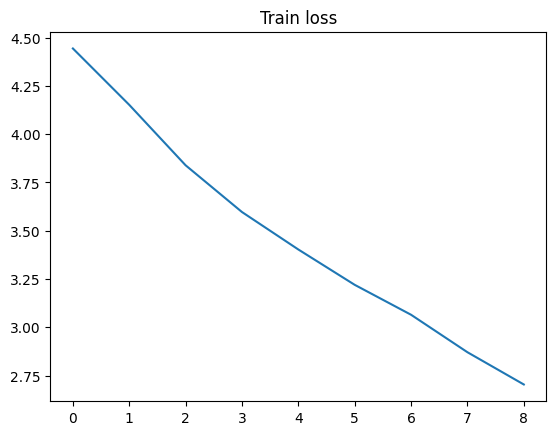

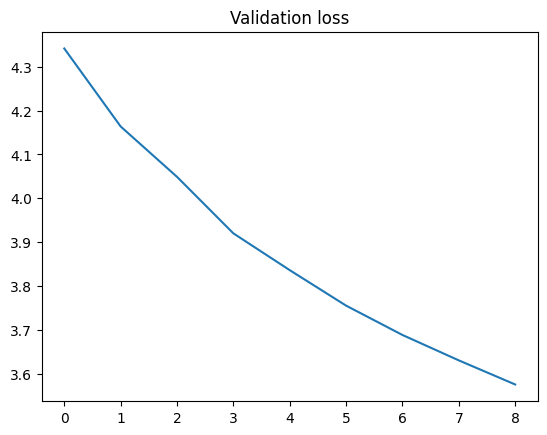

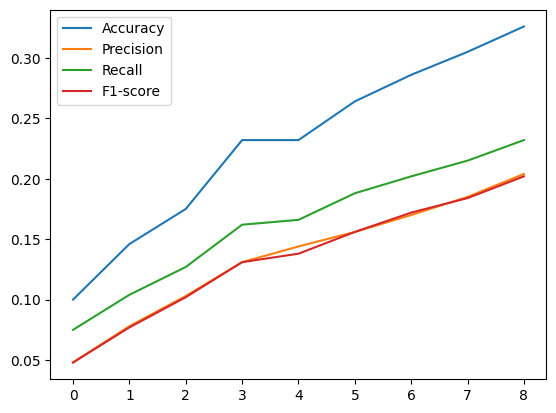

In [21]:
launch(train_loader=train_loader_chroma, val_loader=val_loader_chroma, num_epochs=9, spectrogram_type='chroma')

### As we can see, training on the mel spectrogram is the best, the results on the short-time fourier transform spectrogram's are close to it. Let's do an experiment:

# Model Training with label smoothing

In [23]:
loss_list = []
loss_list_val = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

loss_total = []
loss_total_val = []
accuracy_total = []
precision_total = []
recall_total = []
f1_total = []

In [24]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n = pred.size(1)
        smoothed_labels = torch.full(size=(target.size(0), n), fill_value=self.smoothing / (n - 1)).to(pred.device)
        smoothed_labels.scatter_(dim=1, index=target.unsqueeze(1), value=1 - self.smoothing)
        log_probs = nn.functional.log_softmax(pred, dim=1)
        loss = -torch.sum(smoothed_labels * log_probs, dim=1).mean()
        return loss

def launch_ls(train_loader, val_loader, num_epochs=9, spectrogram_type='mel'):    
    model = ResNetGray182(num_classes=182).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    
    torch.save(model.state_dict(), f'EfficientNet_weights{num_epochs}_{spectrogram_type}.pth')

Iteration: 305 / 305
Validating...
Epoch 1/9, Train loss: 4.009, Validation loss: 3.481, Accuracy: 0.295, Precision: 0.175, Recall: 0.213, F1-score: 0.174

Iteration: 305 / 305
Validating...
Epoch 2/9, Train loss: 3.613, Validation loss: 3.351, Accuracy: 0.358, Precision: 0.231, Recall: 0.259, F1-score: 0.227

Iteration: 305 / 305
Validating...
Epoch 3/9, Train loss: 3.012, Validation loss: 3.220, Accuracy: 0.427, Precision: 0.275, Recall: 0.306, F1-score: 0.272
Iteration: 305 / 305
Validating...
Epoch 4/9, Train loss: 2.759, Validation loss: 3.128, Accuracy: 0.456, Precision: 0.302, Recall: 0.333, F1-score: 0.300

Iteration: 305 / 305
Validating...
Epoch 5/9, Train loss: 2.534, Validation loss: 3.028, Accuracy: 0.520, Precision: 0.365, Recall: 0.383, F1-score: 0.358

Iteration: 305 / 305
Validating...
Epoch 6/9, Train loss: 2.341, Validation loss: 2.947, Accuracy: 0.553, Precision: 0.398, Recall: 0.417, F1-score: 0.392

Iteration: 305 / 305
Validating...
Epoch 7/9, Train loss: 2.144, 

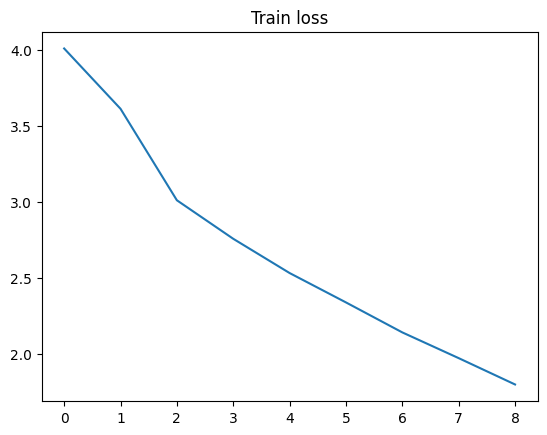

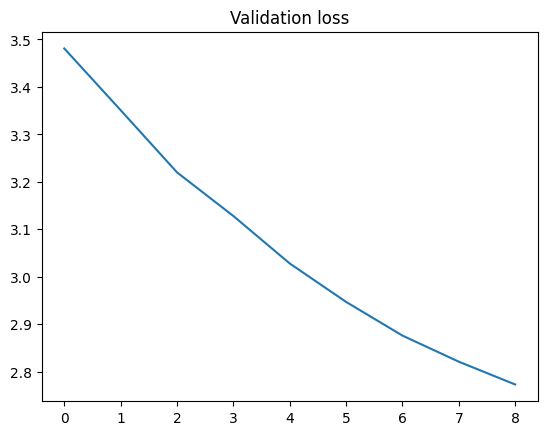

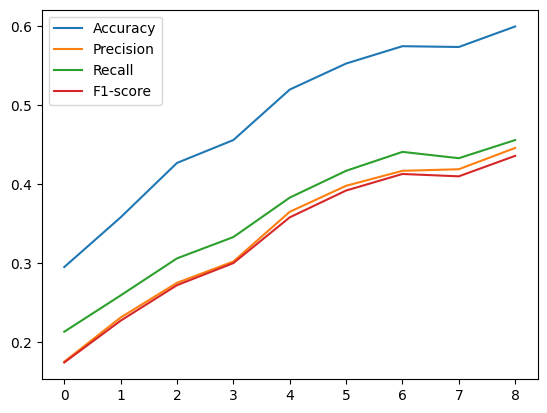

In [23]:
launch_ls(train_loader=train_loader_mel, val_loader=val_loader_mel, num_epochs=9, spectrogram_type='mel')

# Model training with augmentations

Iteration: 305 / 305
Validating...
Epoch 1/9, Train loss: 3.762, Validation loss: 4.064, Accuracy: 0.130, Precision: 0.086, Recall: 0.102, F1-score: 0.080

Iteration: 305 / 305
Validating...
Epoch 2/9, Train loss: 3.408, Validation loss: 3.453, Accuracy: 0.335, Precision: 0.201, Recall: 0.233, F1-score: 0.200

Iteration: 305 / 305
Validating...
Epoch 3/9, Train loss: 2.640, Validation loss: 3.137, Accuracy: 0.403, Precision: 0.257, Recall: 0.285, F1-score: 0.255

Iteration: 305 / 305
Validating...
Epoch 4/9, Train loss: 2.324, Validation loss: 2.969, Accuracy: 0.433, Precision: 0.291, Recall: 0.304, F1-score: 0.282

Iteration: 305 / 305
Validating...
Epoch 5/9, Train loss: 2.070, Validation loss: 2.841, Accuracy: 0.450, Precision: 0.306, Recall: 0.327, F1-score: 0.299

Iteration: 305 / 305
Validating...
Epoch 6/9, Train loss: 1.842, Validation loss: 2.708, Accuracy: 0.513, Precision: 0.363, Recall: 0.374, F1-score: 0.353

Iteration: 305 / 305
Validating...
Epoch 7/9, Train loss: 1.600,

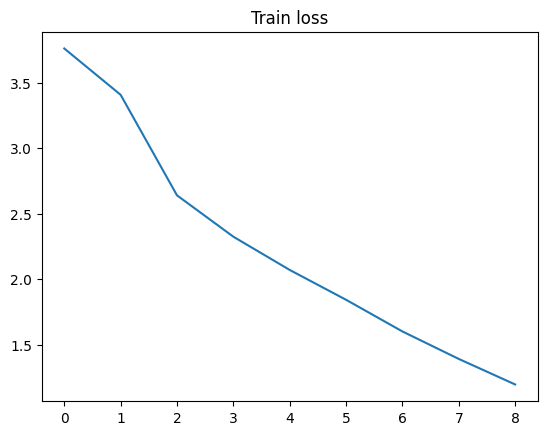

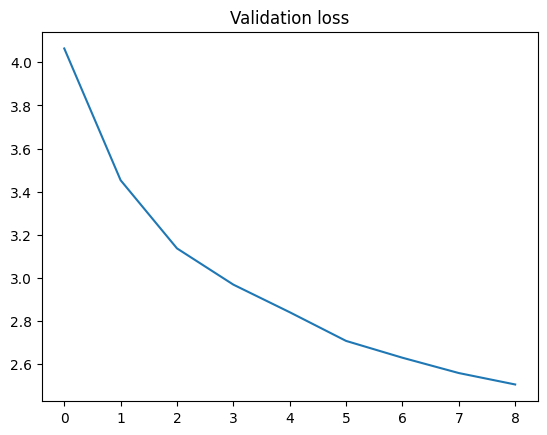

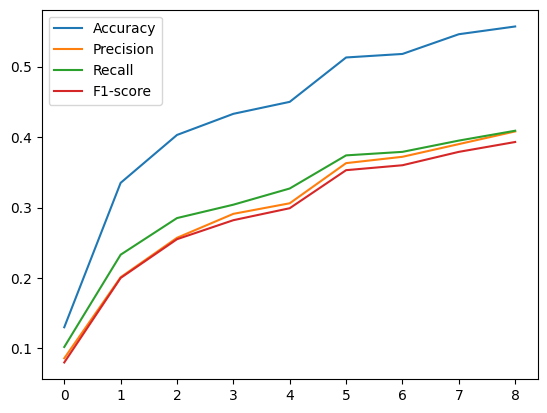

In [25]:
launch(train_loader=train_loader_mel_aug, val_loader=val_loader_mel, num_epochs=9, spectrogram_type='mel')